## Technical TASK 7 :- Stock Market Prediction using Numerical and Textual Analysis
In this task, we will Create a hybrid model for stock price/performance prediction using numerical analysis of historical stock prices, and sentimental analysis of news headlines.
#### Task Completed for The Sparks Foundation Internship Program
#### Data Science & Business Analytics Internship Task_7
###  Author: Qasim Hassan



# What we will learn?

  * Analyzing time series data, the movement of prices and volume of BSE index using rolling window, calculate the percentage change between the current and a prior element using pct_change() function and etc
  * About Altair which is a declarative statistical visualization library for Python
  * Plot Partial Autocorrelation and understand the graph
  * Textual Analysis of news from Times of India News Headlines to determine the sentiment - whether it is a positive text or negative or neutral. And also determine whether the text contains personal opinion or has factual information.
  * Based on both analysis data we will predict the stock price ((high+low+close)/3) and closing price of BSE index
  * Prepare a dataset for training the model to predict tomorrow's stock price ((high+low+close)/3) and closing price of BSE index of which we have no independent variables (we donot have the prices of tomorrow nor we know what will be the news of the day)   
  * We will also learn 
      * What is Multioutput Regression model?
      * Which are the two different types of Multioutput Regression models?
      * Which Multioutput Regression model to select? and 
      * How to predict price ((high+low+close)/3) and closing price of BSE index using Multioutput Regression model?

## Step 0: Importing Libraries needed to perform task

In [1]:
#import libraries 
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import altair as alt  #Altair is a declarative statistical visualization library for Python

import statsmodels.api as sm 

from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.multioutput import RegressorChain
from sklearn.ensemble import RandomForestRegressor

In [2]:
#ignoring the warnings
import warnings
warnings.filterwarnings('ignore')

## Step 1 : Downloading and Reading The Data Set

In [3]:
# import yfinance as yf
# bse_data = yf.download('^BSESN', start='2015-01-01', end='2020-11-03')
# unseenbse_data = yf.download('^BSESN', start='2020-11-03', end='2020-11-04')

In [4]:
pip install yfinance --upgrade --no-cache-dir

Note: you may need to restart the kernel to use updated packages.


In [5]:
import yfinance as yf
bse_data = yf.download('^BSESN', start='2015-01-01', end='2020-06-30')
#since our Textual Analysis dataset containing news from Times of India News Headlines is only till 30th June 2020. 
#So we will assume today is 29th June 2020 and tomorrow is 30th June 2020. And we have to predict the stock price ((high+low+close)/3) and closing price of BSE index 
#for tomorrow 30th June 2020.
unseenbse_data = yf.download('^BSESN', start='2020-06-30', end='2020-07-01')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [6]:
bse_data.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [7]:
unseenbse_data.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [8]:
bse_data.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [9]:
unseenbse_data.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [10]:
bse_data.rename(columns={'Open': 'open', 'High': 'high', 'Low': 'low', 'Close': 'close', 'Adj Close': 'adjclose', 'Volume': 'volume'}, inplace = True)

In [11]:
unseenbse_data.rename(columns={'Open': 'open', 'High': 'high', 'Low': 'low', 'Close': 'close', 'Adj Close': 'adjclose', 'Volume': 'volume'}, inplace = True)

## Step 2 : Checking the dataset's information

In [12]:
bse_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1345 entries, 2015-01-02 to 2020-06-29
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   open      1345 non-null   float64
 1   high      1345 non-null   float64
 2   low       1345 non-null   float64
 3   close     1345 non-null   float64
 4   adjclose  1345 non-null   float64
 5   volume    1345 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 73.6 KB


In [13]:
unseenbse_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1 entries, 2020-06-30 to 2020-06-30
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   open      1 non-null      float64
 1   high      1 non-null      float64
 2   low       1 non-null      float64
 3   close     1 non-null      float64
 4   adjclose  1 non-null      float64
 5   volume    1 non-null      int64  
dtypes: float64(5), int64(1)
memory usage: 56.0 bytes


In [14]:
bse_data.head()

,open,high,low,close,adjclose,volume
Date,,,,,,
2015-01-02,27521.279297,27937.470703,27519.259766,27887.900391,27887.900391,7400
2015-01-05,27978.429688,28064.490234,27786.849609,27842.320312,27842.320312,9200
2015-01-06,27694.230469,27698.929688,26937.060547,26987.460938,26987.460938,14100
2015-01-07,26983.429688,27051.599609,26776.119141,26908.820312,26908.820312,12200
2015-01-08,27178.769531,27316.410156,27101.939453,27274.710938,27274.710938,8200


In [15]:
bse_data.tail()

,open,high,low,close,adjclose,volume
Date,,,,,,
2020-06-23,35015.730469,35482.160156,34843.691406,35430.429688,35430.429688,25200
2020-06-24,35679.738281,35706.550781,34794.929688,34868.980469,34868.980469,26600
2020-06-25,34525.390625,35081.609375,34499.781250,34842.101562,34842.101562,24600
2020-06-26,35144.781250,35254.878906,34910.339844,35171.269531,35171.269531,24800
2020-06-29,34926.949219,35032.359375,34662.058594,34961.519531,34961.519531,18300


In [16]:
unseenbse_data.head()

,open,high,low,close,adjclose,volume
Date,,,,,,
2020-06-30,35168.300781,35233.910156,34812.800781,34915.800781,34915.800781,18500


In [17]:
bse_data.reset_index(inplace=True)

In [18]:
bse_data.rename(columns={'Date': 'date'}, inplace = True)

In [19]:
bse_data.head()

,date,open,high,low,close,adjclose,volume
0,2015-01-02,27521.279297,27937.470703,27519.259766,27887.900391,27887.900391,7400
1,2015-01-05,27978.429688,28064.490234,27786.849609,27842.320312,27842.320312,9200
2,2015-01-06,27694.230469,27698.929688,26937.060547,26987.460938,26987.460938,14100
3,2015-01-07,26983.429688,27051.599609,26776.119141,26908.820312,26908.820312,12200
4,2015-01-08,27178.769531,27316.410156,27101.939453,27274.710938,27274.710938,8200


In [20]:
unseenbse_data.reset_index(inplace=True)

In [21]:
unseenbse_data.rename(columns={'Date': 'date'}, inplace = True)

In [22]:
unseenbse_data.head()

,date,open,high,low,close,adjclose,volume
0,2020-06-30,35168.300781,35233.910156,34812.800781,34915.800781,34915.800781,18500


In [23]:
bse_data['date'] = pd.to_datetime(bse_data['date'], format = '%Y%m%d')

In [24]:
unseenbse_data['date'] = pd.to_datetime(unseenbse_data['date'], format = '%Y%m%d')

In [25]:
#before moving forward let us calculate first the actual price
unseenbsedata_price = round((unseenbse_data['high'] + unseenbse_data['low'] + unseenbse_data['close'])/ 3, 2)
unseenbsedata_price  #actual price

0    34987.5
dtype: float64

# Step 3 : Rolling window analysis of time series

Creating 4,16, 52 week moving average of closing price of BSE index


In [26]:
def stock_weekmovingavg(wks, df):
    dateclose_data = pd.DataFrame({'date': df['date'], 'close':df['close']})
    dateclose_data.set_index('date', inplace=True)
    num = wks * 5                                 #calculating the number of days in the week. 5 days because BSE is open for 5 days / week
    dateclose_data['movingavg'] = dateclose_data['close'].rolling(window=num).mean().shift()
    return dateclose_data.dropna()

In [27]:
stock_weekmovingavg(4, bse_data).head()

,close,movingavg
date,,
2015-02-02,29122.269531,28256.509570
2015-02-03,29000.140625,28318.228027
2015-02-04,28883.109375,28376.119043
2015-02-05,28850.970703,28470.901465
2015-02-06,28717.910156,28568.008984


<AxesSubplot:xlabel='date'>

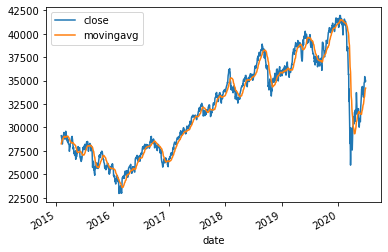

In [28]:
stock_weekmovingavg(4, bse_data).plot()

In [29]:
altdata_fourweek = stock_weekmovingavg(4, bse_data)
altdata_fourweek.reset_index(inplace=True)
altdata_fourweek.rename(columns={list(altdata_fourweek)[0]:'date'}, inplace=True)

In [30]:
alt.Chart(altdata_fourweek).mark_point().encode(
    x='date',
    y='movingavg'
)

alt.Chart(...)

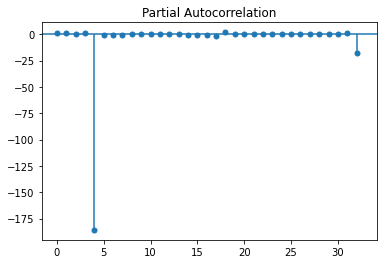

In [31]:
plotfourweek = altdata_fourweek.filter(['date', 'movingavg'], axis=1) #df.copy()
plotfourweek.index = pd.Index(sm.tsa.datetools.dates_from_range('2015', length=len(altdata_fourweek['date']))) 
del plotfourweek['date']
sm.graphics.tsa.plot_pacf(plotfourweek.values.squeeze())
plt.show()

In the partial autocorrelation plot above, we have statistically significant partial autocorrelations at lag values 4 and 32. Since it is less than 0 and more than -1 so 4 and 32 represents a perfect negative correlation. While the rest of values are very close to 0 and under the confidence intervals, which are represented as blue shaded regions (which is not vividly seen in the above plot)

In [32]:
stock_weekmovingavg(16, bse_data).head()

,close,movingavg
date,,
2015-05-05,27440.140625,28447.880933
2015-05-06,26717.369141,28442.283936
2015-05-07,26599.109375,28428.222046
2015-05-08,27105.390625,28423.367651
2015-05-11,27507.300781,28425.824780


<AxesSubplot:xlabel='date'>

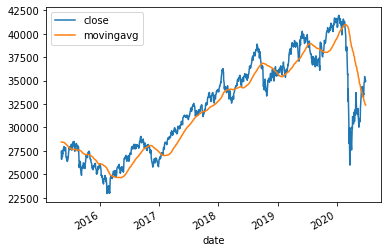

In [33]:
stock_weekmovingavg(16, bse_data).plot()

In [34]:
altdata_sixteenweek = stock_weekmovingavg(16, bse_data)
altdata_sixteenweek.reset_index(inplace=True)
altdata_sixteenweek.rename(columns={list(altdata_sixteenweek)[0]:'date'}, inplace=True)

In [35]:
alt.Chart(altdata_sixteenweek).mark_point().encode(
    x='date',
    y='movingavg'
)

alt.Chart(...)

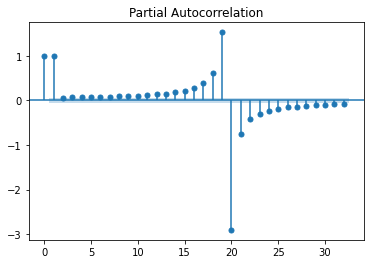

In [36]:
plotsixteenweek = altdata_sixteenweek.filter(['date', 'movingavg'], axis=1) #df.copy()
plotsixteenweek.index = pd.Index(sm.tsa.datetools.dates_from_range('2015', length=len(altdata_sixteenweek['date']))) 
del plotsixteenweek['date']
sm.graphics.tsa.plot_pacf(plotsixteenweek.values.squeeze())
plt.show()

In the partial autocorrelation plot above, we have statistically significant partial autocorrelations at lag values 0, 1, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28.
Where 0, 1, 19 represents a perfect positive correlation and 20 represents a perfect negative correlation.
While the rest of values are very close to 0 and under the confidence intervals, which are represented as blue shaded regions (which is not vividly seen in the above plot)

In [37]:
stock_weekmovingavg(52, bse_data).head()

,close,movingavg
date,,
2016-01-25,24485.949219,27198.907963
2016-01-27,24492.390625,27185.823535
2016-01-28,24469.570312,27172.939190
2016-01-29,24870.689453,27163.254995
2016-02-01,24824.830078,27155.416031


<AxesSubplot:xlabel='date'>

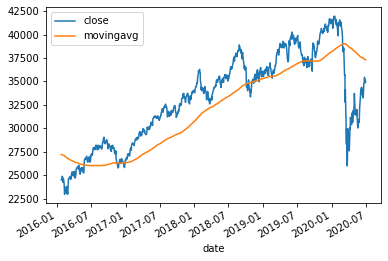

In [38]:
stock_weekmovingavg(52, bse_data).plot()

In [39]:
altdata_fiftytwoweek = stock_weekmovingavg(52, bse_data)
altdata_fiftytwoweek.reset_index(inplace=True)
altdata_fiftytwoweek.rename(columns={list(altdata_fiftytwoweek)[0]:'date'}, inplace=True)

In [40]:
alt.Chart(altdata_fiftytwoweek).mark_point().encode(
    x='date',
    y='movingavg'
)

alt.Chart(...)

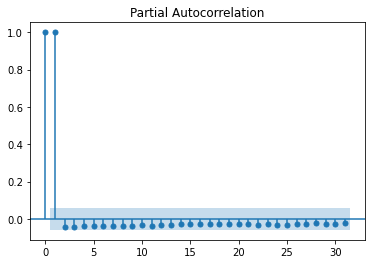

In [41]:
plotfiftytwoweek = altdata_fiftytwoweek.filter(['date', 'movingavg'], axis=1) #df.copy()
plotfiftytwoweek.index = pd.Index(sm.tsa.datetools.dates_from_range('2015', length=len(altdata_fiftytwoweek['date']))) 
del plotfiftytwoweek['date']
sm.graphics.tsa.plot_pacf(plotfiftytwoweek.values.squeeze())
plt.show()

In the partial autocorrelation plot above, we have statistically significant partial autocorrelations at lag values 0, 1 representing a perfect positive correlation. While the rest of values are very close to 0 and under the confidence intervals, which are represented as blue shaded regions 

## Step 4 : Creating a rolling window of size 10 and 50 of the BSE index

In [42]:
def rollingwindows(days, df):
    data = df.filter(['date','open','high','low','close'], axis=1) #df.copy()
    data.set_index('date', inplace=True)
    rollingwindows_data = data.rolling(window=days).mean().shift()
    return rollingwindows_data.dropna()

In [43]:
rollingwindows(10, bse_data).head()

,open,high,low,close
date,,,,
2015-01-16,27515.904883,27657.483008,27279.612891,27479.296484
2015-01-19,27569.437891,27681.345898,27322.217969,27502.695508
2015-01-20,27596.578906,27708.302930,27363.268945,27544.664453
2015-01-21,27659.640820,27821.338867,27502.047852,27724.385352
2015-01-22,27845.606836,28011.988867,27703.692969,27922.389258


<AxesSubplot:xlabel='date'>

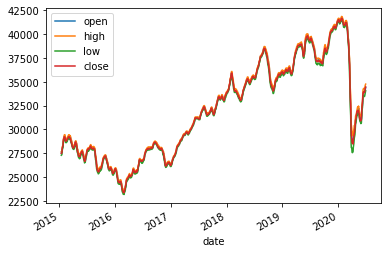

In [44]:
rollingwindows(10, bse_data).plot()

In [45]:
altdata_tendays = rollingwindows(10, bse_data)
altdata_tendays.reset_index(inplace=True)
altdata_tendays.rename(columns={list(altdata_tendays)[0]:'date'}, inplace=True)

In [46]:
alt.Chart(altdata_tendays).mark_point().encode(
    x ='date',
    y = 'close'
)

alt.Chart(...)

In [47]:
rollingwindows(50, bse_data).head()

,open,high,low,close
date,,,,
2015-03-18,28721.847383,28863.956836,28502.767422,28670.602461
2015-03-19,28746.759180,28881.346836,28523.317422,28685.286836
2015-03-20,28763.295000,28899.631836,28535.814414,28697.833828
2015-03-23,28778.719180,28915.340430,28561.266406,28723.306211
2015-03-24,28805.396367,28942.011250,28589.022031,28748.970195


<AxesSubplot:xlabel='date'>

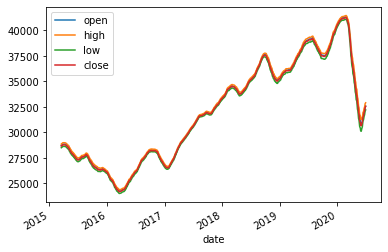

In [48]:
rollingwindows(50, bse_data).plot()

In [49]:
altdata_fiftydays = rollingwindows(50, bse_data)
altdata_fiftydays.reset_index(inplace=True)
altdata_fiftydays.rename(columns={list(altdata_fiftydays)[0]:'date'}, inplace=True)

In [50]:
alt.Chart(altdata_fiftydays).mark_point().encode(
    x='date',
    y='close'
)

alt.Chart(...)

## Step 5 : Creating the dummy time series:

Volume shocks : we will be creating a 0/1 dummy-coded boolean time series for shock, based on whether volume traded is 10% higher/lower than previous day. ( 0/1 dummy-coding is for direction of shock)

In [51]:
def boolean_shock(percent, df, col):
    data = df.filter(['date', col], axis=1) #df.copy()
    data.set_index('date', inplace=True)
    data['percentchg'] = (data[col].pct_change()) * 100  #percentage change compare to previous volume using pct_change() function
    data['shock'] = data['percentchg'].apply(lambda x: 1 if x >= percent else 0)
    data.drop(col, axis = 1, inplace = True)
    return data.dropna()

In [52]:
boolean_shock(10, bse_data, 'volume')

,percentchg,shock
date,,
2015-01-05,24.324324,1
2015-01-06,53.260870,1
2015-01-07,-13.475177,0
2015-01-08,-32.786885,0
2015-01-09,35.365854,1
...,...,...
2020-06-23,0.398406,0
2020-06-24,5.555556,0
2020-06-25,-7.518797,0


In [53]:
altdata_volpercentchg = boolean_shock(10, bse_data, 'volume')
altdata_volpercentchg.reset_index(inplace=True)
altdata_volpercentchg.rename(columns={list(altdata_volpercentchg)[0]:'date'}, inplace=True)

In [54]:
alt.Chart(altdata_volpercentchg).mark_point().encode(
    x='date',
    y='percentchg'
)

alt.Chart(...)

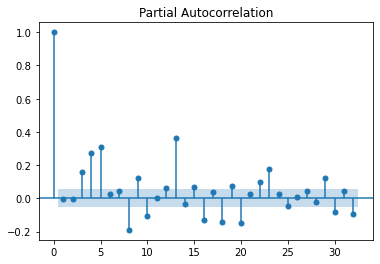

In [55]:
plotvolpercentchg = altdata_volpercentchg.filter(['date', 'percentchg'], axis=1) #df.copy()
plotvolpercentchg.index = pd.Index(sm.tsa.datetools.dates_from_range('2015', length=len(altdata_volpercentchg['date']))) 
del plotvolpercentchg['date']
sm.graphics.tsa.plot_pacf(plotvolpercentchg.values.squeeze())
plt.show()

In the partial autocorrelation plot above, we have statistically significant partial autocorrelations at lag values 0, 3, 4, 5, 8, 9. 10, 12, 13, 15, 16, 18, 19, 20, 22, 23, 29, 30, 32. And lag value 0 represents a perfect positive correlation. While the rest of values are very close to 0 and under the confidence intervals, which are represented as blue shaded regions

In [56]:
boolean_shock(2, bse_data, 'close')

,percentchg,shock
date,,
2015-01-05,-0.163440,0
2015-01-06,-3.070360,0
2015-01-07,-0.291397,0
2015-01-08,1.359742,0
2015-01-09,0.673407,0
...,...,...
2020-06-23,1.486937,0
2020-06-24,-1.584653,0
2020-06-25,-0.077085,0


In [57]:
altdata_closepercentchg2 = boolean_shock(2, bse_data, 'close')
altdata_closepercentchg2.reset_index(inplace=True)
altdata_closepercentchg2.rename(columns={list(altdata_closepercentchg2)[0]:'date'}, inplace=True)

In [58]:
alt.Chart(altdata_closepercentchg2).mark_point().encode(
    x='date',
    y='percentchg'
)

alt.Chart(...)

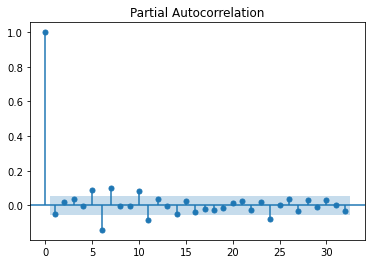

In [59]:
plotclosepercentchg2 = altdata_closepercentchg2.filter(['date', 'percentchg'], axis=1) #df.copy()
plotclosepercentchg2.index = pd.Index(sm.tsa.datetools.dates_from_range('2015', length=len(altdata_closepercentchg2['date']))) 
del plotclosepercentchg2['date']
sm.graphics.tsa.plot_pacf(plotclosepercentchg2.values.squeeze())
plt.show()

In the partial autocorrelation plot above, we have statistically significant partial autocorrelations at lag values 0, 5, 6, 7, 10, 11, 24. And lag value 0 represents a perfect positive correlation. While the rest of values are very close to 0 and under the confidence intervals, which are represented as blue shaded regions

In [60]:
boolean_shock(10, bse_data, 'close')

,percentchg,shock
date,,
2015-01-05,-0.163440,0
2015-01-06,-3.070360,0
2015-01-07,-0.291397,0
2015-01-08,1.359742,0
2015-01-09,0.673407,0
...,...,...
2020-06-23,1.486937,0
2020-06-24,-1.584653,0
2020-06-25,-0.077085,0


In [61]:
altdata_closepercentchg10 = boolean_shock(10, bse_data, 'close')
altdata_closepercentchg10.reset_index(inplace=True)
altdata_closepercentchg10.rename(columns={list(altdata_closepercentchg10)[0]:'date'}, inplace=True)

In [62]:
alt.Chart(altdata_closepercentchg10).mark_point().encode(
    x='date',
    y='percentchg'
)

alt.Chart(...)

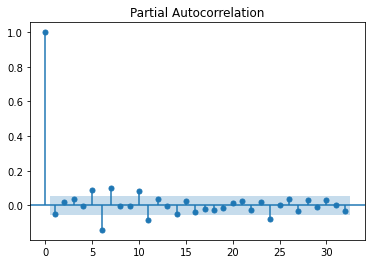

In [63]:
plotclosepercentchg10 = altdata_closepercentchg10.filter(['date', 'percentchg'], axis=1) #df.copy()
plotclosepercentchg10.index = pd.Index(sm.tsa.datetools.dates_from_range('2015', length=len(altdata_closepercentchg10['date']))) 
del plotclosepercentchg10['date']
sm.graphics.tsa.plot_pacf(plotclosepercentchg10.values.squeeze())
plt.show()

In the partial autocorrelation plot above, we have statistically significant partial autocorrelations at lag values 0, 5, 6, 7, 10, 11, 24. And lag value 0 represents a perfect positive correlation. While the rest of values are very close to 0 and under the confidence intervals, which are represented as blue shaded regions

## Step 6 : Pricing shock without volume shock

In [64]:
def priceboolean_shock(percent, df):
    df['date'] = pd.to_datetime(df['date'])
    data = df.filter(['date', 'high', 'low','close'], axis=1) #df.copy()
    data.set_index('date', inplace=True)
    data['priceavg'] = (data['high'] + data['low'] + data['close']) / 3
    data['shock'] = (data['priceavg'].pct_change()) * 100
    data['shock'] = data['shock'].apply(lambda x: 1 if x >= percent else 0)
    data.drop(['high', 'low', 'close'], axis = 1, inplace = True)
    return data

In [65]:
priceboolean_shock(10, bse_data)

,priceavg,shock
date,,
2015-01-02,27781.543620,0
2015-01-05,27897.886719,0
2015-01-06,27207.817057,0
2015-01-07,26912.179688,0
2015-01-08,27231.020182,0
...,...,...
2020-06-23,35252.093750,0
2020-06-24,35123.486979,0
2020-06-25,34807.830729,0


In [66]:
altdata_pricepercentchg = priceboolean_shock(10, bse_data)
altdata_pricepercentchg.reset_index(inplace=True)
altdata_pricepercentchg.rename(columns={list(altdata_pricepercentchg)[0]:'date'}, inplace=True)

In [67]:
alt.Chart(altdata_pricepercentchg).mark_point().encode(
    x='date',
    y='priceavg'
)

alt.Chart(...)

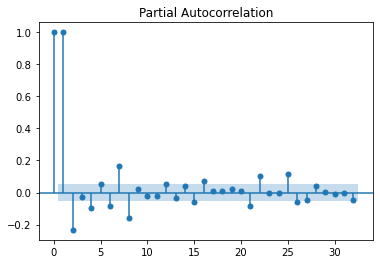

In [68]:
plotpricepercentchg = altdata_pricepercentchg.filter(['date', 'priceavg'], axis=1) #df.copy()
plotpricepercentchg.index = pd.Index(sm.tsa.datetools.dates_from_range('2015', length=len(altdata_pricepercentchg['date']))) 
del plotpricepercentchg['date']
sm.graphics.tsa.plot_pacf(plotpricepercentchg.values.squeeze())
plt.show()

In the partial autocorrelation plot above, we have statistically significant partial autocorrelations at lag values 0, 1, 2, 4, 6, 7, 8, 15, 16, 21, 22, 25, 26. And lag values 0, 1 represents a perfect positive correlation.  While the rest of values are very close to 0 and under the confidence intervals, which are represented as blue shaded regions

## Step 7 : Creating the reverse dummy time series:

Price shocks : we will be creating a 0/1 dummy-coded boolean time series for shock, based on whether closing price at T vs T+1 has a difference > 2%. ( 0/1 dummy-coding is for direction of shock). This will be reverse of pct_change()

In [69]:
def reverseboolean_shock(percent, df, col):
    data = df.filter(['date', col], axis=1) #df.copy()
    data.set_index('date', inplace=True)
    data = data.reindex(index=data.index[::-1])
    data['percentchg'] = (data[col].pct_change()) * 100
    data['shock'] = data['percentchg'].apply(lambda x: 1 if x > percent else 0)
    data.drop(col, axis = 1, inplace = True)
    data = data.reindex(index=data.index[::-1])
    return data.dropna()

In [70]:
reverseboolean_shock(2, bse_data, 'close')

,percentchg,shock
date,,
2015-01-02,0.163708,0
2015-01-05,3.167617,1
2015-01-06,0.292249,0
2015-01-07,-1.341501,0
2015-01-08,-0.668903,0
...,...,...
2020-06-22,-1.465151,0
2020-06-23,1.610168,0
2020-06-24,0.077145,0


In [71]:
altdata_closepercentchg = reverseboolean_shock(2, bse_data, 'close')
altdata_closepercentchg.reset_index(inplace=True)
altdata_closepercentchg.rename(columns={list(altdata_closepercentchg)[0]:'date'}, inplace=True)

In [72]:
alt.Chart(altdata_closepercentchg).mark_point().encode(
    x='date',
    y='percentchg'
)

alt.Chart(...)

Pricing black swan : we will be creating a 0/1 dummy-coded boolean time series for shock, based on whether closing price at T vs T+1 has a difference > 5%. ( 0/1 dummy-coding is for direction of shock). This will be reverse of pct_change()

In [73]:
reverseboolean_shock(5, bse_data, 'close')

,percentchg,shock
date,,
2015-01-02,0.163708,0
2015-01-05,3.167617,0
2015-01-06,0.292249,0
2015-01-07,-1.341501,0
2015-01-08,-0.668903,0
...,...,...
2020-06-22,-1.465151,0
2020-06-23,1.610168,0
2020-06-24,0.077145,0


In [74]:
altdata_closepercentchg5 = reverseboolean_shock(5, bse_data, 'close')
altdata_closepercentchg5.reset_index(inplace=True)
altdata_closepercentchg5.rename(columns={list(altdata_closepercentchg5)[0]:'date'}, inplace=True)

In [75]:
alt.Chart(altdata_closepercentchg5).mark_point().encode(
    x='date',
    y='percentchg'
)

alt.Chart(...)

Pricing shock without volume shock : Now we will be creating a time series for pricing shock without volume shock based on whether price at T vs T+1 has a difference > 2%. ( 0/1 dummy-coding is for direction of shock). This will be reverse of pct_change()



In [76]:
def pricereverseboolean_shock(percent, df):
    data = df.filter(['date', 'high', 'low','close'], axis=1) #df.copy()
    data.set_index('date', inplace=True)
    data = data.reindex(index=data.index[::-1])
    data['reversepriceavg'] = (data['high'] + data['low'] + data['close']) / 3
    data['shock'] = (data['reversepriceavg'].pct_change()) * 100
    data['shock'] = data['shock'].apply(lambda x: 1 if x >= percent else 0)
    data.drop(['high', 'low', 'close'], axis = 1, inplace = True)
    data = data.reindex(index=data.index[::-1])
    return data.dropna()

In [77]:
pricereverseboolean_shock(2, bse_data)

,reversepriceavg,shock
date,,
2015-01-02,27781.543620,0
2015-01-05,27897.886719,1
2015-01-06,27207.817057,0
2015-01-07,26912.179688,0
2015-01-08,27231.020182,0
...,...,...
2020-06-23,35252.093750,0
2020-06-24,35123.486979,0
2020-06-25,34807.830729,0


In [78]:
altdata_reversepricepercentchg = pricereverseboolean_shock(2, bse_data)
altdata_reversepricepercentchg.reset_index(inplace=True)
altdata_reversepricepercentchg.rename(columns={list(altdata_reversepricepercentchg)[0]:'date'}, inplace=True)

In [79]:
alt.Chart(altdata_reversepricepercentchg).mark_point().encode(
    x='date',
    y='reversepriceavg'
)

alt.Chart(...)

## Step 8 : Textual Analysis of news from Times of India News Headlines

In [80]:
#reading the uploaded csv file and assigning to news variable
news  = pd.read_csv('newdata.csv')

In [81]:
#getting the overview of all the columns in the news dataset
news.columns

Index(['publish_date', 'headline_category', 'headline_text'], dtype='object')

In [82]:
#finding the total rows and columns of news dataset
news.shape

(3424067, 3)

In [83]:
#first 5 rows content of the dataset
news.head()

,publish_date,headline_category,headline_text
0,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
1,20010102,unknown,Fissures in Hurriyat over Pak visit
2,20010102,unknown,America's unwanted heading for India?
3,20010102,unknown,For bigwigs; it is destination Goa
4,20010102,unknown,Extra buses to clear tourist traffic


In [84]:
#converting publish_date column to 
news['publish_date'] = pd.to_datetime(news['publish_date'], format = '%Y%m%d')

In [85]:
#first 5 rows content of the dataset
news.head()

,publish_date,headline_category,headline_text
0,2001-01-02,unknown,Status quo will not be disturbed at Ayodhya; s...
1,2001-01-02,unknown,Fissures in Hurriyat over Pak visit
2,2001-01-02,unknown,America's unwanted heading for India?
3,2001-01-02,unknown,For bigwigs; it is destination Goa
4,2001-01-02,unknown,Extra buses to clear tourist traffic


In [86]:
#last 5 rows content of the dataset
news.tail()

,publish_date,headline_category,headline_text
3424062,2020-12-31,city.jodhpur,Covid-19: Despite dip in cases; Rajasthan amon...
3424063,2020-12-31,city.udaipur,Covid-19: Despite dip in cases; Rajasthan amon...
3424064,2020-12-31,city.ajmer,Covid-19: Despite dip in cases; Rajasthan amon...
3424065,2020-12-31,removed,Govt extends deadline for use of FASTag till F...
3424066,2020-12-31,entertainment.bengali.movies.news,Celebs plan to party safely and responsibly on...


In [87]:
#getting brief overview of the dataset - number of columns and rows (shape of dataset), columns names and its dtype, how many non-null values it has and memory usage.
news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3424067 entries, 0 to 3424066
Data columns (total 3 columns):
 #   Column             Dtype         
---  ------             -----         
 0   publish_date       datetime64[ns]
 1   headline_category  object        
 2   headline_text      object        
dtypes: datetime64[ns](1), object(2)
memory usage: 78.4+ MB


In [88]:
#finding unique values in headline_category
news['headline_category'].unique()

array(['unknown', 'entertainment.hindi.bollywood', 'india', ...,
       'elections.assembly-elections.bihar',
       'astrology.horoscope.monthly', 'astrology.numerology-tarot'],
      dtype=object)

In [89]:
#checking all the values count (unique values total count)
news['headline_category'].value_counts()

india                                                    288541
unknown                                                  209582
city.mumbai                                              134428
city.delhi                                               127717
business.india-business                                  116761
                                                          ...  
brandwire.technology.internet-apps                            8
sports.asian-games-2018                                       8
entertainment.hindi.music.singer-of-the-week                  8
best-products.home-decor-and-garden.living-room-decor         8
sports.rio-2016-olympics.news.sailing                         8
Name: headline_category, Length: 1013, dtype: int64

In [90]:
#total unique values count
news['headline_category'].value_counts().count()

1013

In [91]:
#checking all the values count (unique values total count)
news['headline_text'].value_counts()

Straight Answers                                          6723
Cartoons                                                  1536
Straight answers                                          1500
Photogallery                                              1353
Your say                                                  1012
                                                          ... 
Prison fire in Iran kills 27                                 1
Rail Budget: Steel companies to gain from new tracks         1
Mohanlal and Major Ravi join 'The Chase'                     1
Terrorism needs to be tackled unitedly: Tharoor              1
This Kottayam school has its annual study tour to NASA       1
Name: headline_text, Length: 3168800, dtype: int64

In [92]:
#total unique values count
news['headline_text'].value_counts().count()

3168800

In [93]:
#finding if any null values are present
news.isnull().sum().sum()

0

In [94]:
#finding if any duplicate values are present
news.duplicated().sum()

24191

In [95]:
#rough checking by marking all duplicates as True. Default is first which marks duplicates as True except for the first occurrence.
news.duplicated(keep=False).sum()

46130

In [96]:
#sorting the dataset to delete the duplicates, to make duplicates come together one after another. The sorted dataset index values are also changed
cols = list(news.columns)
news.sort_values(by=cols, inplace=True, ignore_index=True)

In [97]:
news[news.duplicated(keep=False)]

,publish_date,headline_category,headline_text
3,2001-01-02,unknown,America's unwanted heading for India?
4,2001-01-02,unknown,America's unwanted heading for India?
5,2001-01-02,unknown,America's unwanted heading for India?
6,2001-01-02,unknown,America's unwanted heading for India?
9,2001-01-02,unknown,BBC's reality TV will focus on AIIMS
...,...,...,...
3421893,2020-12-27,city.nagpur,Govt forcing helpless sr citizens to fight leg...
3422119,2020-12-28,city.bareilly,Rampur's Hunar Haat a platform for artisans fr...
3422120,2020-12-28,city.bareilly,Rampur's Hunar Haat a platform for artisans fr...
3422956,2020-12-29,city.pune,PMC to draft separate DP after 23 villages' me...


In [98]:
#dropping the duplicates only keeping the last value (ordinally last row from sorted) of each duplicates
news.drop_duplicates(keep='last', inplace=True, ignore_index=True)

In [99]:
#re-checking everything worked well with drop_duplicates() carried out earlier on the dataset
news.duplicated().sum()

0

In [100]:
pip install textblob

Note: you may need to restart the kernel to use updated packages.


In [101]:
from textblob import TextBlob

In [102]:
#getting a list of unique dates in publish_date column
lst = news['publish_date'].value_counts().index.tolist()

In [103]:
#concatenating all the headline_text column values of same date in publish_date column
new = []
for x in lst:
    df = news.loc[news['publish_date'] == x]
    headlinetext = ''
    publishdate = str(x)
    headlinetext = df['headline_text'].iloc[0]
    for i in range(1 , len(df)):
        headlinetext = headlinetext + '. '+ df['headline_text'].iloc[i]  
    new.append(headlinetext)

In [104]:
#creating a new dataset
newsdf = pd.DataFrame({'publish_date': lst, 'headline_text' : new})

In [105]:
newsdf

,publish_date,headline_text
0,2014-12-15,Golden Homes III. Golden Panorama. Hanging Gar...
1,2014-12-21,Eight companies add Rs 55;171 crore in m-cap; ...
2,2014-12-09,Audi-Vredestein driving experience. Benelli TN...
3,2014-11-29,6 CARE IPO merchant bankers fined Rs 1 crore. ...
4,2014-11-01,Chetan Bhagat: Cleanliness begins at home. Gau...
...,...,...
7257,2001-03-13,Expose rocks nation
7258,2001-06-02,Indo-US Ties: Denim; Denim ka Bandhan?
7259,2001-03-05,The Buddha Smiles
7260,2001-03-16,Tape and Tell


In [106]:
#sorting the dataset based on dates
newsdf.sort_values(by='publish_date', inplace=True, ignore_index=True)

In [107]:
newsdf.head()

,publish_date,headline_text
0,2001-01-02,Raju Chacha. A noisy effort to spruce up Comme...
1,2001-01-03,'Devdas': Jinxed?. 10-year-old girl missing. 3...
2,2001-01-04,Car dealers caught in Bihar sales tax ruling. ...
3,2001-01-05,Nepal won't allow anti-India activities: Envoy...
4,2001-01-06,Anti-immigration think-tank berates Clinton re...


In [108]:
newsdf.tail()

,publish_date,headline_text
7257,2020-12-27,Horoscope Today; 27 December 2020: Check astro...
7258,2020-12-28,Horoscope Today; 28 December 2020: Check astro...
7259,2020-12-29,Horoscope Today; 29 December 2020: Check astro...
7260,2020-12-30,Horoscope Today; 30 December 2020: Check astro...
7261,2020-12-31,Horoscope Today; 31 December 2020: Check astro...


In [109]:
newsdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7262 entries, 0 to 7261
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   publish_date   7262 non-null   datetime64[ns]
 1   headline_text  7262 non-null   object        
dtypes: datetime64[ns](1), object(1)
memory usage: 113.6+ KB


We can calculate the sentiment using TextBlob. Based on the polarity, we determine whether it is a positive text or negative or neutral. For TextBlog, if the polarity is more than 0, it is considered positive, if it is less than 0 then it is considered negative and if it ia=s equal to 0 is considered neutral. Subjectivity quantifies the amount of personal opinion and factual information contained in the text. The higher subjectivity means that the text contains personal opinion rather than factual information. 

In [110]:
polarity = []
subjectivity = []
for idx, row in newsdf.iterrows():
    polarity.append(TextBlob(row['headline_text']).sentiment[0])
    subjectivity.append(TextBlob(row['headline_text']).sentiment[1])

In [111]:
newsdf['polarity'] = polarity
newsdf['subjectivity'] = subjectivity

In [112]:
newsdf.head()

,publish_date,headline_text,polarity,subjectivity
0,2001-01-02,Raju Chacha. A noisy effort to spruce up Comme...,0.193519,0.293056
1,2001-01-03,'Devdas': Jinxed?. 10-year-old girl missing. 3...,0.088462,0.407692
2,2001-01-04,Car dealers caught in Bihar sales tax ruling. ...,0.091426,0.481895
3,2001-01-05,Nepal won't allow anti-India activities: Envoy...,0.257415,0.465542
4,2001-01-06,Anti-immigration think-tank berates Clinton re...,0.219481,0.464935


In [113]:
newsdf.tail()

,publish_date,headline_text,polarity,subjectivity
7257,2020-12-27,Horoscope Today; 27 December 2020: Check astro...,0.035346,0.396452
7258,2020-12-28,Horoscope Today; 28 December 2020: Check astro...,0.070784,0.414510
7259,2020-12-29,Horoscope Today; 29 December 2020: Check astro...,0.061175,0.424021
7260,2020-12-30,Horoscope Today; 30 December 2020: Check astro...,0.043919,0.441660
7261,2020-12-31,Horoscope Today; 31 December 2020: Check astro...,0.092529,0.406220


In [114]:
#finding if any null values are present
newsdf.isnull().sum().sum()

0

In [115]:
#renameing the publish_date to date so it will help us during joining this dataset with bse_data dataset
newsdf.rename(columns={'publish_date': 'date'}, inplace = True)

In [116]:
#selecting required columns
newsdf = newsdf.filter(['date', 'polarity', 'subjectivity'], axis=1)

In [117]:
newsdf.shape

(7262, 3)

In [118]:
newsdf['date'].duplicated().sum()

0

In [119]:
bse_data.shape

(1345, 7)

In [120]:
bse_data['date'].duplicated().sum()

0

In [121]:
bse_data = pd.merge(bse_data, newsdf, how='left', on=['date'])

In [122]:
bse_data.shape

(1345, 9)

In [123]:
bse_data.head()

,date,open,high,low,close,adjclose,volume,polarity,subjectivity
0,2015-01-02,27521.279297,27937.470703,27519.259766,27887.900391,27887.900391,7400,0.055586,0.455251
1,2015-01-05,27978.429688,28064.490234,27786.849609,27842.320312,27842.320312,9200,0.100081,0.433132
2,2015-01-06,27694.230469,27698.929688,26937.060547,26987.460938,26987.460938,14100,0.055802,0.386579
3,2015-01-07,26983.429688,27051.599609,26776.119141,26908.820312,26908.820312,12200,0.034707,0.386916
4,2015-01-08,27178.769531,27316.410156,27101.939453,27274.710938,27274.710938,8200,0.060173,0.408416


In [124]:
bse_data.tail()

,date,open,high,low,close,adjclose,volume,polarity,subjectivity
1340,2020-06-23,35015.730469,35482.160156,34843.691406,35430.429688,35430.429688,25200,0.067428,0.370002
1341,2020-06-24,35679.738281,35706.550781,34794.929688,34868.980469,34868.980469,26600,0.088329,0.387802
1342,2020-06-25,34525.390625,35081.609375,34499.781250,34842.101562,34842.101562,24600,0.023232,0.401736
1343,2020-06-26,35144.781250,35254.878906,34910.339844,35171.269531,35171.269531,24800,0.069594,0.381331
1344,2020-06-29,34926.949219,35032.359375,34662.058594,34961.519531,34961.519531,18300,0.056935,0.387858


In [125]:
#finding if any null values are present
bse_data.isnull().sum().sum()

0

# Step 9 : Preparing the dataset for machine learning

In [126]:
#adding new row for 30th June 2020 (price to be predicted of this day) to main dataset to get average values of all the columns for this day
#taking average because we don't know the values of all the columns for tomorrow so to predict we need average for independent variable.
#We will separate this row later from this main dataset so we can use this as prediction of unseen data for tomorrow. 
#And then tally it with actual data from unseenbse_data dataset which we have downloaded too for 30th June 2020 actual values
bse_data.loc[len(bse_data)] = ['2020-06-30', bse_data['open'].mean(), bse_data['high'].mean(), bse_data['low'].mean(),
                       bse_data['close'].mean(), bse_data['adjclose'].mean(), bse_data['volume'].median(), newsdf['polarity'].mean(), newsdf['subjectivity'].mean() ]

In [127]:
#converting date from object dtype to datetime dtype
bse_data['date'] = pd.to_datetime(bse_data['date'], format="%Y-%m-%d")

In [128]:
bse_data.tail()

,date,open,high,low,close,adjclose,volume,polarity,subjectivity
1341,2020-06-24,35679.738281,35706.550781,34794.929688,34868.980469,34868.980469,26600.0,0.088329,0.387802
1342,2020-06-25,34525.390625,35081.609375,34499.781250,34842.101562,34842.101562,24600.0,0.023232,0.401736
1343,2020-06-26,35144.781250,35254.878906,34910.339844,35171.269531,35171.269531,24800.0,0.069594,0.381331
1344,2020-06-29,34926.949219,35032.359375,34662.058594,34961.519531,34961.519531,18300.0,0.056935,0.387858
1345,2020-06-30,32032.534800,32180.642524,31806.772791,31984.237075,31984.237075,12700.0,0.069503,0.403839


In [129]:
bse_data["month"] = bse_data['date'].dt.month
bse_data["day"] = bse_data['date'].dt.day
bse_data["dayofweek"] = bse_data['date'].dt.dayofweek
bse_data["week"] = bse_data['date'].dt.week
bse_data['movingavg4weeks'] = round(bse_data['close'].rolling(window=(4*5), min_periods = 1).mean().shift(),2)
bse_data['movingavg16weeks'] = round(bse_data['close'].rolling(window=(16*5), min_periods = 1).mean().shift(),2) #add 12 weeks to 4 weeks 
bse_data['movingavg28weeks'] = round(bse_data['close'].rolling(window=(28*5), min_periods = 1).mean().shift(),2) #add 12 weeks to 16 weeks
bse_data['movingavg40weeks'] = round(bse_data['close'].rolling(window=(40*5), min_periods = 1).mean().shift(),2) #add 12 weeks to 28 weeks
bse_data['movingavg52weeks'] = round(bse_data['close'].rolling(window=(52*5), min_periods = 1).mean().shift(),2)  #add 12 weeks to 40 weeks
bse_data['window10days'] = round(bse_data['close'].rolling(window = 10, min_periods = 1).mean().shift(),2)  
bse_data['window50days'] = round(bse_data['close'].rolling(window = 50, min_periods = 1).mean().shift(),2)
bse_data['volumeshock'] = round(boolean_shock(10, bse_data, 'volume').reset_index()['shock'], 2)
bse_data['closeshock2'] = round(reverseboolean_shock(2, bse_data, 'close').reset_index()['shock'], 2)
bse_data['closeshock5'] = round(reverseboolean_shock(5, bse_data, 'close').reset_index()['shock'],2)
bse_data['closeshock10'] = round(reverseboolean_shock(10, bse_data, 'close').reset_index()['shock'], 2)
bse_data['priceshock'] = round(priceboolean_shock(10, bse_data).reset_index()['shock'], 2)
bse_data['reversebooleanshock2'] = round(reverseboolean_shock(2, bse_data, 'close').reset_index()['shock'], 2)
bse_data['reversebooleanshock5'] = round(reverseboolean_shock(5, bse_data, 'close').reset_index()['shock'], 2)
bse_data['pricereverseshock2'] = round(pricereverseboolean_shock(2, bse_data).reset_index()['shock'], 2)
bse_data['polarity'] = round(bse_data['polarity'] , 2)
bse_data['subjectivity'] = round(bse_data['subjectivity'] , 2)
bse_data['price'] = round((bse_data['high'] + bse_data['low'] + bse_data['close']) / 3 , 2)
bse_data['close'] = round(bse_data['close'] , 2)

In [130]:
bse_data.columns

Index(['date', 'open', 'high', 'low', 'close', 'adjclose', 'volume',
       'polarity', 'subjectivity', 'month', 'day', 'dayofweek', 'week',
       'movingavg4weeks', 'movingavg16weeks', 'movingavg28weeks',
       'movingavg40weeks', 'movingavg52weeks', 'window10days', 'window50days',
       'volumeshock', 'closeshock2', 'closeshock5', 'closeshock10',
       'priceshock', 'reversebooleanshock2', 'reversebooleanshock5',
       'pricereverseshock2', 'price'],
      dtype='object')

In [131]:
bse_data

,date,open,high,low,close,adjclose,volume,polarity,subjectivity,month,...,window50days,volumeshock,closeshock2,closeshock5,closeshock10,priceshock,reversebooleanshock2,reversebooleanshock5,pricereverseshock2,price
0,2015-01-02,27521.279297,27937.470703,27519.259766,27887.90,27887.900391,7400.0,0.06,0.46,1,...,NaN,1.0,0.0,0.0,0.0,0,0.0,0.0,0,27781.54
1,2015-01-05,27978.429688,28064.490234,27786.849609,27842.32,27842.320312,9200.0,0.10,0.43,1,...,27887.90,1.0,1.0,0.0,0.0,0,1.0,0.0,1,27897.89
2,2015-01-06,27694.230469,27698.929688,26937.060547,26987.46,26987.460938,14100.0,0.06,0.39,1,...,27865.11,0.0,0.0,0.0,0.0,0,0.0,0.0,0,27207.82
3,2015-01-07,26983.429688,27051.599609,26776.119141,26908.82,26908.820312,12200.0,0.03,0.39,1,...,27572.56,0.0,0.0,0.0,0.0,0,0.0,0.0,0,26912.18
4,2015-01-08,27178.769531,27316.410156,27101.939453,27274.71,27274.710938,8200.0,0.06,0.41,1,...,27406.63,1.0,0.0,0.0,0.0,0,0.0,0.0,0,27231.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1341,2020-06-24,35679.738281,35706.550781,34794.929688,34868.98,34868.980469,26600.0,0.09,0.39,6,...,32303.70,0.0,0.0,0.0,0.0,0,0.0,0.0,0,35123.49
1342,2020-06-25,34525.390625,35081.609375,34499.781250,34842.10,34842.101562,24600.0,0.02,0.40,6,...,32377.89,0.0,0.0,0.0,0.0,0,0.0,0.0,0,34807.83
1343,2020-06-26,35144.781250,35254.878906,34910.339844,35171.27,35171.269531,24800.0,0.07,0.38,6,...,32460.93,0.0,0.0,0.0,0.0,0,0.0,0.0,0,35112.16
1344,2020-06-29,34926.949219,35032.359375,34662.058594,34961.52,34961.519531,18300.0,0.06,0.39,6,...,32556.76,0.0,1.0,1.0,0.0,0,1.0,1.0,1,34885.31


In [132]:
#fillinf the null columns
bse_data.fillna(method = 'bfill', inplace = True)

In [133]:
#fillinf the null columns
bse_data.fillna(method = 'ffill', inplace = True)

In [134]:
#finding if any null values are present
bse_data.isnull().sum().sum()

0

In [135]:
#selecting specific columns
bse_data = bse_data.filter(['month', 'day', 'dayofweek', 'week',
       'movingavg4weeks', 'movingavg16weeks', 'movingavg28weeks',
       'movingavg40weeks', 'movingavg52weeks', 'window10days', 'window50days',
       'volumeshock', 'closeshock2', 'closeshock5', 'closeshock10',
       'priceshock', 'reversebooleanshock2', 'reversebooleanshock5',
       'pricereverseshock2', 'polarity', 'subjectivity', 'price', 'close'], axis=1)

In [136]:
bse_data

,month,day,dayofweek,week,movingavg4weeks,movingavg16weeks,movingavg28weeks,movingavg40weeks,movingavg52weeks,window10days,...,closeshock5,closeshock10,priceshock,reversebooleanshock2,reversebooleanshock5,pricereverseshock2,polarity,subjectivity,price,close
0,1,2,4,1,27887.90,27887.90,27887.90,27887.90,27887.90,27887.90,...,0.0,0.0,0,0.0,0.0,0,0.06,0.46,27781.54,27887.90
1,1,5,0,2,27887.90,27887.90,27887.90,27887.90,27887.90,27887.90,...,0.0,0.0,0,1.0,0.0,1,0.10,0.43,27897.89,27842.32
2,1,6,1,2,27865.11,27865.11,27865.11,27865.11,27865.11,27865.11,...,0.0,0.0,0,0.0,0.0,0,0.06,0.39,27207.82,26987.46
3,1,7,2,2,27572.56,27572.56,27572.56,27572.56,27572.56,27572.56,...,0.0,0.0,0,0.0,0.0,0,0.03,0.39,26912.18,26908.82
4,1,8,3,2,27406.63,27406.63,27406.63,27406.63,27406.63,27406.63,...,0.0,0.0,0,0.0,0.0,0,0.06,0.41,27231.02,27274.71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1341,6,24,2,26,33762.67,32586.53,36265.58,37002.15,37367.90,34118.98,...,0.0,0.0,0,0.0,0.0,0,0.09,0.39,35123.49,34868.98
1342,6,25,3,26,33925.86,32517.85,36221.64,36989.02,37350.08,34181.17,...,0.0,0.0,0,0.0,0.0,0,0.02,0.40,34807.83,34842.10
1343,6,26,4,26,34057.94,32449.86,36176.72,36975.03,37330.89,34311.54,...,0.0,0.0,0,0.0,0.0,0,0.07,0.38,35112.16,35171.27
1344,6,29,0,27,34195.30,32390.89,36136.56,36963.62,37313.42,34450.58,...,1.0,0.0,0,1.0,1.0,1,0.06,0.39,34885.31,34961.52


In [137]:
#separating the predicted date row from main dataset after getting all the calculated average values
main_bsedata = bse_data.iloc[:1345,:].reset_index()  
newtestunseen_bsedata = bse_data.iloc[1345:,:].reset_index()  

In [138]:
main_bsedata.shape

(1345, 24)

In [139]:
main_bsedata.tail()

,index,month,day,dayofweek,week,movingavg4weeks,movingavg16weeks,movingavg28weeks,movingavg40weeks,movingavg52weeks,...,closeshock5,closeshock10,priceshock,reversebooleanshock2,reversebooleanshock5,pricereverseshock2,polarity,subjectivity,price,close
1340,1340,6,23,1,26,33521.62,32658.27,36304.08,37008.50,37384.51,...,0.0,0.0,0,0.0,0.0,0,0.07,0.37,35252.09,35430.43
1341,1341,6,24,2,26,33762.67,32586.53,36265.58,37002.15,37367.90,...,0.0,0.0,0,0.0,0.0,0,0.09,0.39,35123.49,34868.98
1342,1342,6,25,3,26,33925.86,32517.85,36221.64,36989.02,37350.08,...,0.0,0.0,0,0.0,0.0,0,0.02,0.40,34807.83,34842.10
1343,1343,6,26,4,26,34057.94,32449.86,36176.72,36975.03,37330.89,...,0.0,0.0,0,0.0,0.0,0,0.07,0.38,35112.16,35171.27
1344,1344,6,29,0,27,34195.30,32390.89,36136.56,36963.62,37313.42,...,1.0,0.0,0,1.0,1.0,1,0.06,0.39,34885.31,34961.52


In [140]:
newtestunseen_bsedata.shape

(1, 24)

In [141]:
newtestunseen_bsedata.head()

,index,month,day,dayofweek,week,movingavg4weeks,movingavg16weeks,movingavg28weeks,movingavg40weeks,movingavg52weeks,...,closeshock5,closeshock10,priceshock,reversebooleanshock2,reversebooleanshock5,pricereverseshock2,polarity,subjectivity,price,close
0,1345,6,30,1,27,34278.2,32331.09,36094.84,36953.09,37293.01,...,1.0,0.0,0,1.0,1.0,0,0.07,0.4,31990.55,31984.24


# Step 10 : Training the model and predicting the price of 30th June 2020

In [142]:
X = main_bsedata.drop(['price','close'], axis = 1)
y = main_bsedata[['price','close']]

In [143]:
Xnewtestunseen = newtestunseen_bsedata.drop(['price','close'], axis = 1)
ynewtestunseen_ans = newtestunseen_bsedata[['price','close']]

In [144]:
X.shape, y.shape

((1345, 22), (1345, 2))

In [145]:
Xnewtestunseen.shape, ynewtestunseen_ans.shape

((1, 22), (1, 2))

In [146]:
split = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
for train_index, test_index in split.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [147]:
 X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1076, 22), (1076, 2), (269, 22), (269, 2))

There are two ways to predict values of two columns one is

  * Direct Multioutput Regression:
  
  It involves seperating each target variable as independent regression problem, that is here it presumably assumes the outputs to be independent of each other.

  * Chained Multioutput Regression:

  It involves creating a series of regression models from single output regression model, that is the first model in the sequence uses the input and predicts one output then the second model uses the input and the output from the first model to make a prediction and it goes on depending on the number of target variables.


In this case Chained Multioutput Regression will be more appropriate option as the stock price ((high+low+close)/3) and closing price are interdependent.

In [148]:
rfg = RandomForestRegressor(random_state = 42, n_estimators = 500, criterion='mse', max_depth = 30, min_samples_leaf=2, min_samples_split=5, n_jobs=1)

In [149]:
chainedmodel = RegressorChain(rfg)
chainedmodel.fit(X_train, y_train)

RegressorChain(base_estimator=RandomForestRegressor(max_depth=30,
                                                    min_samples_leaf=2,
                                                    min_samples_split=5,
                                                    n_estimators=500, n_jobs=1,
                                                    random_state=42))

In [150]:
pred = chainedmodel.predict(X_test)
roundpred = []
for x in range(len(pred)):
    roundpred.append([round(pred[x][0], 2),round(pred[x][1], 2) ])


In [151]:
r2_score(y_test, roundpred) 

0.9946337613559171

In [152]:
#evaluating the performance of the model
#MAE
print('MAE')
print(mean_absolute_error(y_test, roundpred), end='\n')
#MSE
print('MSE')
print(mean_squared_error(y_test, roundpred), end='\n')
#RMSE
print('RMSE')
print(np.sqrt(mean_squared_error(y_test, roundpred)))

MAE
256.34442379182144
MSE
130058.0266204461
RMSE
360.6355870133258


In [153]:
pred_newtestunseen = chainedmodel.predict(Xnewtestunseen)

In [154]:
[(round(pred_newtestunseen[0][0], 2)),(round(pred_newtestunseen[0][1], 2))]

[35080.53, 34989.02]

In [155]:
ynewtestunseen_ans  #used average of high, low, close, volume to calculate price ((high+low+close)/3) and close value

,price,close
0,31990.55,31984.24


In [156]:
[unseenbsedata_price[0] , round(unseenbse_data['close'],2)[0]] #actual price ((high+low+close)/3) calculated earlier and the closing price

[34987.5, 34915.8]

The model predicted for 30th June 2020 the price ((high+low+close)/3) i.e the average of high, low, close of BSE index to be 35020.02 and closing price to be 34955.46

And the actual price ((high+low+close)/3) i.e the average of high, low, close of BSE index on day 30th June 2020 was 34987.5, and closing price was 34915.8

So as seen above our model has done a very good prediction